In [26]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from scipy.integrate import simpson

In [27]:
# Constants

D = 100
z_H = 100
C_star = 4.5
f = 1e-4
kappa = 0.4
z_0 = 0.0001
s_x = 10
s_y = 10
U_0 = 10.0
C_T = 0.8
RL = 100 * D

In [28]:
# TDM FUNCTION

def calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c):

    c_t = (np.pi * C_T * D**2)/(8 * s_d * s_c)

    nu_star = 28 * np.sqrt(c_t)
    
    beta =  nu_star / (1 + nu_star)
    
    z_0WF = z_H * (1 + D/(2 * z_H))**beta * np.exp(-kappa * (c_t + (kappa/np.log((z_H / z_0) * (1 - D/(2 * z_H))**beta))**2)**-0.5)

    x = np.linspace(x_1, x_3+1, int(x_3))

    h1 = np.full_like(x, np.nan, dtype=float)
    h2 = np.full_like(x, np.nan, dtype=float)

    h1[x > x_1] = z_H + ((x[x > x_1]) / z_0WF)**(4/5)
    h2[x > x_2] = ((x[x>x_2]-x_2)/z_0WF)**(4.03/5)

    uw = np.full_like(x, np.nan, dtype=float)
    uw[0] = U_0

    idx1 = h1 >= z_H
    uw[idx1] = U_0 * (np.log(h1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h1[idx1] / z_0WF) * np.log(z_H/z_0))

    idx2 = (x > x_2) & (h2 >= z_H)
    uw[idx2] = U_0 * (np.log(h1[idx2] / z_0) * np.log(h2[idx2] / z_0WF)) / (np.log(h1[idx2] / z_0WF) * np.log(h2[idx2] / z_0))

    for i in range(1, len(uw)):
        if uw[i] > 10.0:
            uw[i] = 10.0
        elif uw[i] < 0.0:
            uw[i] = 0.0

    return x, uw

In [29]:
# Park Setup
theta_deg = 0
theta = np.radians(theta_deg)
resolution = 10

# Define the unit vectors in original directions
dx = np.array([s_x, 0])
dy = np.array([0, s_y])

# Rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Rotate the unit vectors
dx_rot = R @ dx
dy_rot = R @ dy

# Projected spacings along global x and y
s_x_global = np.abs(dx_rot)
s_y_global = np.abs(dy_rot)

s_x = s_x_global[0] + s_x_global[1]
s_y = s_y_global[0] + s_y_global[1]

#print(f"s_x: {s_x}, s_y: {s_y}")

# Initialize thrust curve
u = np.arange(0, 26, .5)  # [m/s]
C_T_var = np.array([0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0])

# Interpolate thrust curve
u_interp = np.linspace(u.min(), u.max(), 1000)
C_T_interp = interp1d(u, C_T_var, kind='linear')(u_interp)

"""
plt.figure(figsize=(6, 4))
plt.plot(C_T_interp, label='Thrust Coefficient (C_T)')
plt.xlabel('Index')
plt.ylabel('C_T')
plt.title('Thrust Coefficient (C_T) Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(6, 4))\nplt.plot(C_T_interp, label='Thrust Coefficient (C_T)')\nplt.xlabel('Index')\nplt.ylabel('C_T')\nplt.title('Thrust Coefficient (C_T) Values')\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n"

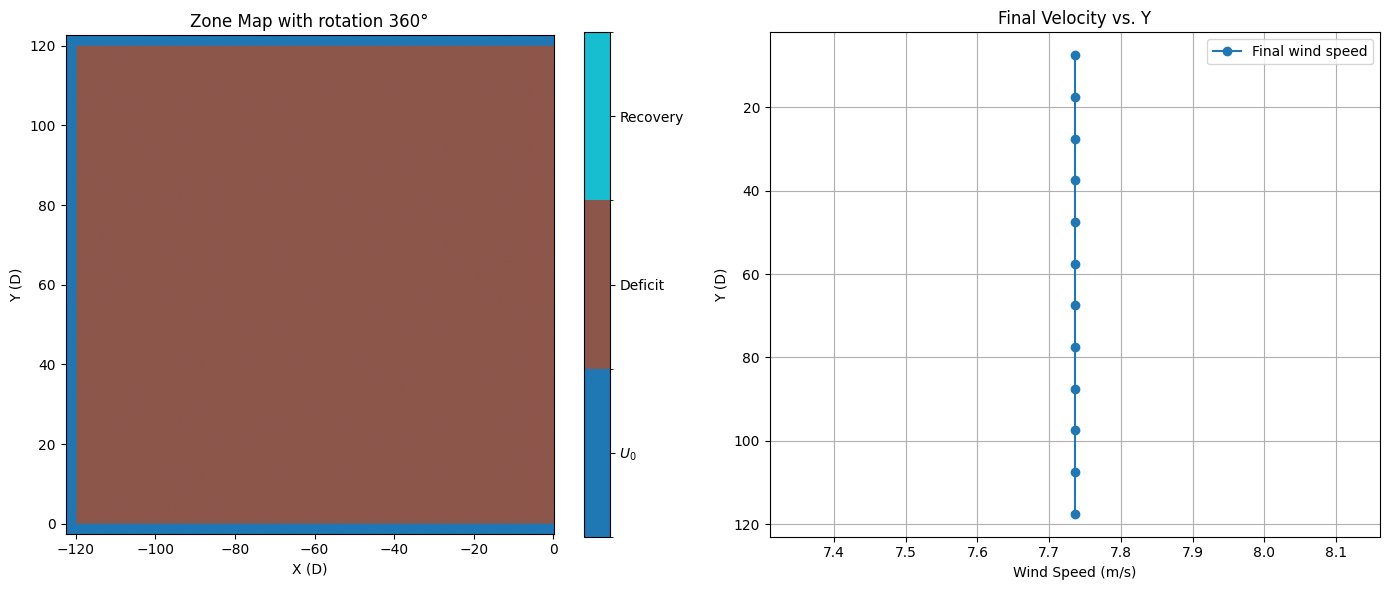

In [30]:
# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 250  # meters
    y_padding = 250  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding


    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range


# --- Define park shape ---
corner_points = [(0, 0), (12000, 0), (12000, 12000), (0, 12000)]  # Rectangle
rotation_degrees = 360
mirror_axis = 'x'
recovery_x_end = 0 # set recovery limit

# Generate mask
mask_2d, x_range, y_range = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size == 0:
        # Ensure rows with no park mask are cleared
        zone_map[row_idx] = ZONE_UH0
        continue


    if true_indices.size > 0:
        # Identify gaps between clusters of ones
        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        # Mark each deficit segment
        for start, end in zip(segment_starts, segment_ends):
            zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

        # Mark gaps in between as recovery
        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

        # Mark recovery zone after the last deficit
        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()

# --- Improved Post-processing: Remove deficit after the last mask in each row ---
for i in range(zone_map.shape[0]):
    # Find last column with mask=1 (i.e. inside the park)
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]

    # Set all ZONE_DEFICIT values to ZONE_RECOVERY beyond the mask
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

# Arbitrary TDM 

y_resolution = int((s_y * D)/resolution)

results = []

for y_idx in range(0, len(y_range), y_resolution):
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    # Identify all contiguous non-zero zones (deficit or recovery)
    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):  # Note: range goes one past the end now
    # At the end of row or if zone changes
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):  # Don't update past end of row
                start_idx = idx
                current_zone_type = row[idx]

# Initialize velocity profile collector with more data
final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0  # Set U_h0 as a constant 10 m/s

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        # Nygaard setup
        x, uw = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)

        # ---------------------------------------------------------------

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue

        deficit_end_uw = uw[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        # Update or overwrite any previous entry for this y
        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)


        i += 2
    else:
        i += 1

# Convert to structured array: [y, final_velocity, x_start, x_end]
final_velocity_profile1 = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

# === Combined Plot: Zone Map and Final Velocity Profile ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Zone Map Plot (Left) ---
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])  # Blue, Brown, Cyan
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = axes[0].imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
axes[0].set_title(f"Zone Map with rotation {rotation_degrees}°")
axes[0].set_xlabel("X (D)")
axes[0].set_ylabel("Y (D)")
axes[0].set_aspect('equal')

# Optional colorbar
cbar = fig.colorbar(im, ax=axes[0], ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['$U_0$', 'Deficit', 'Recovery'])

# --- Velocity Profile Plot (Right) ---
axes[1].plot(final_velocity_profile1[:, 1], final_velocity_profile1[:, 0]/D, marker='o', label='Final wind speed')
axes[1].set_title("Final Velocity vs. Y")
axes[1].set_xlabel("Wind Speed (m/s)")
axes[1].set_ylabel("Y (D)")
axes[1].grid(True)
axes[1].legend()

# Flip y-axis so Y=0 is at bottom like the zone map
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# tdm_x0_momentum

In [31]:
y_vals = final_velocity_profile1[:, 0]
ws_vals = final_velocity_profile1[:, 1]

ws_interp = interp1d(y_vals, ws_vals, kind='linear', fill_value='extrapolate')

def y_int_bounds():
    y_bounds = [pt[1] for pt in corner_points]
    return min(y_bounds), max(y_bounds)

y_min, y_max = y_int_bounds()

y_range = np.linspace(y_min, y_max, y_max - y_min)

ws_array = ws_interp(y_range)

rho = 1.225

tdm_x0_momentum = simpson(rho * (U_0 - ws_array)**2)

print(tdm_x0_momentum)

75354.20799900449


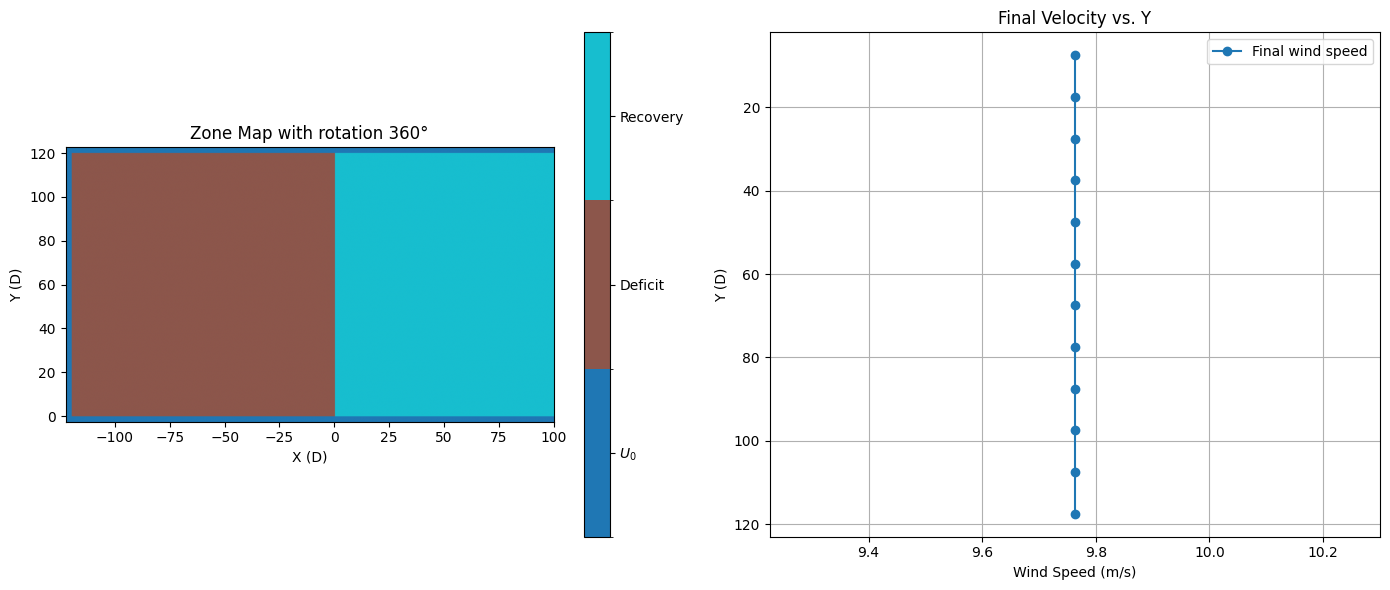

In [32]:
# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 250  # meters
    y_padding = 250  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding


    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range


# --- Define park shape ---
corner_points = [(0, 0), (12000, 0), (12000, 12000), (0, 12000)]  # Rectangle
rotation_degrees = 360
mirror_axis = 'x'
recovery_x_end = RL  # set recovery limit

# Generate mask
mask_2d, x_range, y_range = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size == 0:
        # Ensure rows with no park mask are cleared
        zone_map[row_idx] = ZONE_UH0
        continue


    if true_indices.size > 0:
        # Identify gaps between clusters of ones
        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        # Mark each deficit segment
        for start, end in zip(segment_starts, segment_ends):
            zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

        # Mark gaps in between as recovery
        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

        # Mark recovery zone after the last deficit
        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()

# --- Improved Post-processing: Remove deficit after the last mask in each row ---
for i in range(zone_map.shape[0]):
    # Find last column with mask=1 (i.e. inside the park)
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]

    # Set all ZONE_DEFICIT values to ZONE_RECOVERY beyond the mask
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

# Arbitrary TDM 

y_resolution = int((s_y * D)/resolution)

results = []

for y_idx in range(0, len(y_range), y_resolution):
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    # Identify all contiguous non-zero zones (deficit or recovery)
    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):  # Note: range goes one past the end now
    # At the end of row or if zone changes
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):  # Don't update past end of row
                start_idx = idx
                current_zone_type = row[idx]

# Initialize velocity profile collector with more data
final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0  # Set U_h0 as a constant 10 m/s

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        # Nygaard setup
        x, uw = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)

        # ---------------------------------------------------------------

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue

        deficit_end_uw = uw[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        # Update or overwrite any previous entry for this y
        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)


        i += 2
    else:
        i += 1

# Convert to structured array: [y, final_velocity, x_start, x_end]
final_velocity_profile1 = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

# === Combined Plot: Zone Map and Final Velocity Profile ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Zone Map Plot (Left) ---
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])  # Blue, Brown, Cyan
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = axes[0].imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
axes[0].set_title(f"Zone Map with rotation {rotation_degrees}°")
axes[0].set_xlabel("X (D)")
axes[0].set_ylabel("Y (D)")
axes[0].set_aspect('equal')

# Optional colorbar
cbar = fig.colorbar(im, ax=axes[0], ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['$U_0$', 'Deficit', 'Recovery'])

# --- Velocity Profile Plot (Right) ---
axes[1].plot(final_velocity_profile1[:, 1], final_velocity_profile1[:, 0]/D, marker='o', label='Final wind speed')
axes[1].set_title("Final Velocity vs. Y")
axes[1].set_xlabel("Wind Speed (m/s)")
axes[1].set_ylabel("Y (D)")
axes[1].grid(True)
axes[1].legend()

# Flip y-axis so Y=0 is at bottom like the zone map
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Gausser med bevarelse


Momentum from TDM: 75354.2080 kg·m/s
Momentum from model: 2699.3745 kg·m/s
Momentum after scaling: 96.6983 kg·m/s
Relative momentum error after scaling: 99.87%


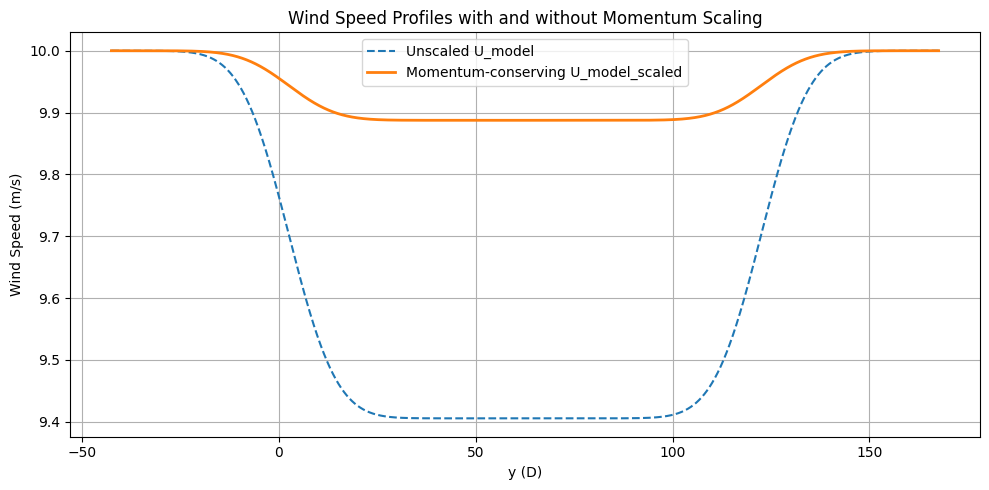

In [ ]:
recovery_x_end = RL
x_array = recovery_x_end - final_velocity_profile1[:, 3]
y_tdm = final_velocity_profile1[:, 0]
U_tdm = final_velocity_profile1[:, 1]

def generate_momentum_conserving_profile_variable_x(y_tdm, U_tdm, x_array, U_inf, CT, rho=1.225):
    k = 0.1
    b = 0.5 * (1 + np.sqrt(1 - CT)) / np.sqrt(1 - CT)
    epsilon = 0.2 * np.sqrt(b)

    sigma_abs_array = k * x_array + epsilon
    min_sigma = np.min(sigma_abs_array)
    y_fine = np.linspace(min(y_tdm) - 5 * min_sigma, max(y_tdm) + 5 * min_sigma, len(ws_array))

    gaussians = []
    for i in range(len(y_tdm)):
        delta_U_i = U_inf - U_tdm[i]
        sigma_i = sigma_abs_array[i]
        gaussian = delta_U_i * np.exp(-((y_fine - y_tdm[i])**2) / (2 * sigma_i**2))

    total_deficit = np.sum(gaussians, axis=0)

    total_momentum_deficit = simpson(rho * total_deficit**2)

    scale = np.sqrt(total_momentum_deficit / tdm_x0_momentum)
    total_momentum_deficit_scaled = total_deficit * scale
    U_model = U_inf - total_deficit
    U_model_scaled = U_inf - total_momentum_deficit_scaled

    print(f"\nMomentum from TDM: {tdm_x0_momentum:.4f} kg·m/s")
    print(f"Momentum from model: {total_momentum_deficit:.4f} kg·m/s")
    print(f"Momentum after scaling: {total_momentum_deficit * scale**2:.4f} kg·m/s")
    print(f"Relative momentum error after scaling: {abs(tdm_x0_momentum - total_momentum_deficit * scale**2) / tdm_x0_momentum * 100:.2f}%")

    return y_fine, U_model_scaled, U_model, (y_tdm, U_tdm), total_deficit

# Function call
y_fine, U_model_scaled, U_model, (y_tdm_out, U_tdm_out), total_deficit = generate_momentum_conserving_profile_variable_x(
    y_tdm, U_tdm, x_array, U_0, C_T
)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_fine/D, U_model, label='Unscaled U_model', linestyle='--')
plt.plot(y_fine/D, U_model_scaled, label='Momentum-conserving U_model_scaled', linewidth=2)
plt.xlabel('y (D)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Profiles with and without Momentum Scaling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()